In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [3]:
import shapely
from analysis_toolbox import *
import pandas as pd 
import numpy as np 
import pickle as pkl
from tqdm import tqdm 
#DATA_DIR="sampletopworst5"
DATA_DIR="final_all_tiles"

In [4]:
def QjGTLSA(A_thres,SAVE=False):
    '''
    GT inclusion, Large Small Area (LSA) Tile EM Worker model 
    Compute the set of Worker qualities
    A_thres: Area threshold
    Qn1,Qp1,Qn1,Qp2
    ngt : not included in ground truth 
    gt : included in ground truth 
    '''
    my_BBG  = pd.read_csv("my_ground_truth.csv")
    os.chdir(DATA_DIR)
    Qp1=[]
    Qp2=[]
    Qn1=[]
    Qn2=[]
    for object_id in tqdm(list(set(my_BBG.object_id))[:1]):
        ground_truth_match = my_BBG[my_BBG.object_id==object_id]
        x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
        T = Polygon(zip(x_locs,y_locs))
        tiles = pkl.load(open("vtiles{}.pkl".format(object_id)))
        indMat = pkl.load(open("indMat{}.pkl".format(object_id)))
        workers = pkl.load(open("worker{}.pkl".format(object_id)))
        for wid,j in zip(workers,range(len(workers))):
            large_gt_Ncorrect=0
            large_gt_Nwrong = 0
            small_gt_Ncorrect=0
            small_gt_Nwrong = 0
            large_ngt_Ncorrect=0
            large_ngt_Nwrong = 0
            small_ngt_Ncorrect=0
            small_ngt_Nwrong = 0
            for k in range(len(tiles)): 
                tk = tiles[k]
                ljk = indMat[j][k]
                try:
                    overlap = T.intersection(tk).area/T.area>0.8
                    tjkInT = T.contains(tk) or overlap
                except(shapely.geos.TopologicalError):
                    overlap=True
                    tjkInT = T.contains(tk)
                if tk.area>A_thres:
                    if (ljk ==1 and tjkInT):
                        large_gt_Ncorrect+=1
                    elif (ljk ==0 and tjkInT):
                        large_gt_Nwrong+=1
                    elif (ljk ==0 and (not tjkInT)):
                        large_ngt_Ncorrect+=1
                    elif (ljk ==1 and (not tjkInT)):
                        large_ngt_Nwrong+=1
                else:
                    if (ljk ==1 and tjkInT):
                        small_gt_Ncorrect+=1
                    elif (ljk ==0 and tjkInT):
                        small_gt_Nwrong+=1
                    elif (ljk ==0 and (not tjkInT)):
                        small_ngt_Ncorrect+=1
                    elif (ljk ==1 and (not tjkInT)):
                        small_ngt_Nwrong+=1
            try:
                qp1 = large_gt_Ncorrect/float(large_gt_Ncorrect+large_gt_Nwrong)
            except(ZeroDivisionError):
                qp1 = -1
            try:
                qn1 = large_ngt_Ncorrect/float(large_ngt_Ncorrect+large_ngt_Nwrong)
            except(ZeroDivisionError):
                qn1 = -1
            try:
                qp2 = small_gt_Ncorrect/float(small_gt_Ncorrect+small_gt_Nwrong)
            except(ZeroDivisionError):
                qp2 = -1
            try:
                qn2 = small_ngt_Ncorrect/float(small_ngt_Ncorrect+small_ngt_Nwrong)
            except(ZeroDivisionError):
                qn2 = -1

            Qp1.append([object_id,wid,qp1])
            Qp2.append([object_id,wid,qp2])
            Qn1.append([object_id,wid,qn1])
            Qn2.append([object_id,wid,qn2])
    Qp1_tbl = pd.DataFrame(Qp1,columns=["object_id","worker_id","Qp1"])
    Qp2_tbl = pd.DataFrame(Qp2,columns=["object_id","worker_id","Qp2"])
    Qn1_tbl = pd.DataFrame(Qn1,columns=["object_id","worker_id","Qn1"])
    Qn2_tbl = pd.DataFrame(Qn2,columns=["object_id","worker_id","Qn2"])
    Qp = Qp1_tbl.merge(Qp2_tbl)
    Qn = Qn1_tbl.merge(Qn2_tbl)
    Qj = Qp.merge(Qn)
    if SAVE:
        pkl.dump(Qj,open("Qgt12_A>{}.pkl".format(A_thres),'w'))
    os.chdir("..")
    return Qj

In [5]:
qj = QjGTLSA(10)

In [6]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis


Check worker 75 has high Qp1 because he got the central head right but it has bad Qn because it significantly overbounds, espectially on a large area (i.e. low Qn1) 

In [11]:
qj[qj["worker_id"]==75]

,object_id,worker_id,Qp1,Qp2,Qn1,Qn2
0,1,75,1,0.423954,0.436364,0.502725


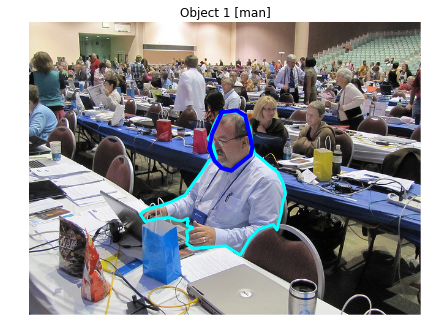

In [7]:
visualize_bb_objects(object_id=1,worker_id=75)

For a worker that draws a pretty decent bounding box, all the Qp and Qn are high because its both precise and bounding all that its suppose to bound

In [13]:
qj[qj["worker_id"]==234]

,object_id,worker_id,Qp1,Qp2,Qn1,Qn2
27,1,234,1,0.747148,0.818182,0.80545


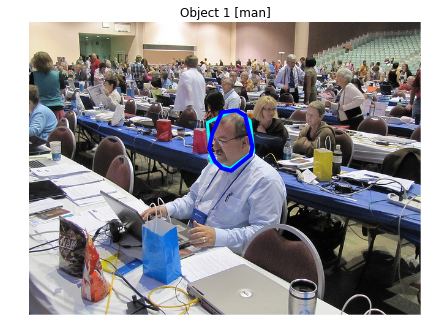

In [9]:
visualize_bb_objects(object_id=1,worker_id=234)

Not really sure why the Qp1 is so low here, but everything else seems to make sense

In [15]:
qj[qj["worker_id"]==238]

,object_id,worker_id,Qp1,Qp2,Qn1,Qn2
28,1,238,0.571429,0.496198,0.418182,0.292098


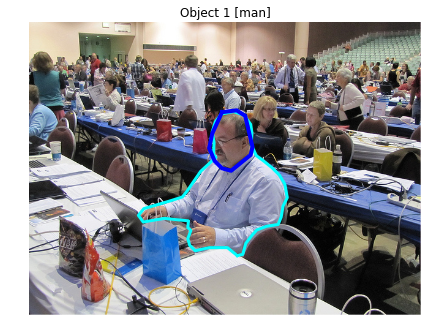

In [16]:
visualize_bb_objects(object_id=1,worker_id=238)

# pTprime calculation

In [18]:
def pTprimeGTLSA(objid,Tprime,T,A_thres):
    '''
    Area Based Tile EM Worker model 
    Given a tile combination Tprime, compute likelihood of that T'=T
    '''
    Qj=pkl.load(open("Qgt12_A>{}.pkl".format(A_thres),'r'))
    tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
    workers = pkl.load(open("worker{}.pkl".format(objid)))
    indicatorMat= pkl.load(open("indMat{}.pkl".format(objid)))
    plk=[]
    for k in Tprime: 
        for j in range(len(workers)):
            tk = tiles[k]
            ljk = indicatorMat[j][k]
            tjkInT = T.contains(tk) 
            wid=workers[j]
            qp1 = float(Qj[(Qj["object_id"]==objid)&(Qj["worker_id"]==wid)]["Qp1"])
            qp2 = float(Qj[(Qj["object_id"]==objid)&(Qj["worker_id"]==wid)]["Qp2"])
            qn1 = float(Qj[(Qj["object_id"]==objid)&(Qj["worker_id"]==wid)]["Qp1"])
            qn2 = float(Qj[(Qj["object_id"]==objid)&(Qj["worker_id"]==wid)]["Qp2"])
            if tk.area>A_thres:
                if (ljk ==1 and tjkInT):
                    plk.append(qp1)
                elif (ljk ==0 and tjkInT):
                    plk.append(1-qp1)
                elif (ljk ==0 and (not tjkInT)):
                    plk.append(qn1)
                elif (ljk ==1 and (not tjkInT)):
                    plk.append(1-qn1)
            else:
                if (ljk ==1 and tjkInT):
                    plk.append(qp2)
                elif (ljk ==0 and tjkInT):
                    plk.append(1-qp2)
                elif (ljk ==0 and (not tjkInT)):
                    plk.append(qn2)
                elif (ljk ==1 and (not tjkInT)):
                    plk.append(1-qn2)
    pTprime=np.product(plk)
    return pTprime

### pTprime code that takes existing Tprime and just computes additional score(T') 

In [20]:
cd TileEM/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [21]:
pd.read_csv("final_all_tiles/obj1to31_tile_combo_metric_area.csv")

BB2TileExact.py                      analysis_toolbox.py                  outputsample/                        runQj.py
BB2TileExact.pyc                     analysis_toolbox.pyc                 qualityBaseline.py                   runRandTileTraining.py
OldGammaTileCode/                    dataset.pyc                          qualityBaseline.pyc                  runSamplingWorkerExperiments.py
Qj_no_overlap_exact_containment.pkl  final_all_tiles/                     runAllDownstreamAnalysis.sh          runUniquifyTiles.py
TileEM_Models.py                     main.py                              runDualPR.py                         sampletopworst5/
TileEM_Models.pyc                    main.pyc                             runExperiments.py                    submitSampleWorkers.sh
TileEM_plot_toolbox.py               my_ground_truth.csv                  runIndicatorMat.py                   vtiles17.pkl
TileEM_plot_toolbox.pyc              output/                              runLossiness

In [22]:
pd.read_csv("final_all_tiles/all_tile_combo_metric_area.csv")

,Unnamed: 0,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,pTprime,pTprime[Athres>1],pTprime[Athres>10],pTprime[Athres>50],pTprime[Athres>100],pTprimeGTLSA[Athres>1],pTprimeGTLSA[Athres>5],Precision,Recall
0,0,1,[1974 3336 3374],67,22.333333,0,NaN,207.385207,69.128402,2.549473e-30,3.722924e-30,3.789426e-29,4.300937e-24,2.193329e-25,8.595849e-51,0,0.393442,0.016202
1,1,1,[2101 3674 2781 3374 2783],105,21.000000,0,NaN,22905.345230,4581.069046,6.052607e-49,9.515039e-49,3.782932e-47,4.233930e-42,7.057121e-40,3.538305e-79,0,0.189696,0.862797
2,2,1,[2781 2783 3374 285 3767 2583 3336 3674],190,23.750000,0,NaN,23242.395516,2905.299439,1.148879e-79,7.925874e-79,3.307696e-75,4.224780e-67,1.417392e-60,9.807650e-141,0,0.190540,0.879389
3,3,1,[2783 3374 2583 2781 1974 285],125,20.833333,0,NaN,18933.033094,3155.505516,7.563700e-59,6.703806e-58,9.745295e-56,4.349753e-49,1.248640e-49,3.308505e-97,0,0.009162,0.034444
4,4,1,[3767 1974 2781 2101 3374 3336 2583],136,19.428571,0,NaN,18874.790215,2696.398602,6.468131e-68,1.868631e-67,2.044115e-65,1.473446e-63,7.541151e-59,1.185650e-105,0,0.013409,0.050256
5,5,1,[3374 2781 285 2583],64,16.000000,0,NaN,18787.170608,4696.792652,1.020312e-39,2.717416e-39,1.021099e-38,3.231015e-36,1.727804e-30,2.767847e-56,0,0.009233,0.034444
6,6,1,[3767],29,29.000000,0,NaN,49.395457,49.395457,1.181928e-09,1.881979e-09,9.171169e-09,1.167388e-09,1.171153e-09,1.318862e-20,0,0.000000,0.000000
7,7,1,[2781 3374 2101],41,13.666667,0,NaN,18599.749183,6199.916394,1.082213e-28,1.032869e-28,1.073258e-28,6.604461e-28,1.480837e-24,1.302870e-36,0,0.009220,0.034054
8,8,1,[2783 2781 2101 3674 2583 3336 3767 285],192,24.000000,0,NaN,23251.095704,2906.386963,8.617885e-80,6.196007e-79,5.196457e-75,1.689527e-69,1.061936e-60,1.169046e-140,0,0.190469,0.879389
9,9,1,[2101 2783 3767 2583 285 3336],128,21.333333,0,NaN,532.661112,88.776852,1.540888e-59,6.725838e-59,1.474290e-56,2.635475e-55,1.638528e-49,4.304646e-98,0,0.156873,0.016593


#### Fix pTPrime to be log likelihood 

In [27]:
cd final_all_tiles/

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM/final_all_tiles


In [48]:
Qj=pkl.load(open("Qgt12_A>5.pkl",'r'))

In [49]:
Qj

,object_id,worker_id,Qp1,Qp2,Qn1,Qn2
0,1,75,0.857143,0.420039,0.413043,0.505158
1,1,114,1.000000,0.951830,0.282609,0.260942
2,1,116,0.857143,0.597303,0.463768,0.653471
3,1,118,0.857143,0.398844,0.463768,0.474770
4,1,133,1.000000,0.685934,0.166667,0.209088
5,1,140,0.785714,0.260116,0.471014,0.512963
6,1,131,1.000000,0.608863,0.442029,0.572902
7,1,146,1.000000,0.578035,0.876812,0.863117
8,1,148,0.857143,0.287091,0.485507,0.619459
9,1,137,1.000000,0.560694,0.333333,0.377195


In [ ]:
if tk.area>A_thres:
                if (ljk ==1 and tjkInT):
                    plk*=qp1
                elif (ljk ==0 and tjkInT):
                    plk*=(1-qp1)
                elif (ljk ==0 and (not tjkInT)):
                    plk*=qn1
                elif (ljk ==1 and (not tjkInT)):
                    plk*=(1-qn1)
            else:
                if (ljk ==1 and tjkInT):
                    plk*=qp2
                elif (ljk ==0 and tjkInT):
                    plk*=(1-qp2)
                elif (ljk ==0 and (not tjkInT)):
                    plk*=qn2
                elif (ljk ==1 and (not tjkInT)):
                    plk*=(1-qn2)

In [122]:
log(0)

-inf

In [129]:
def logsafe(x):
    if x==0:
        return 
    else:
        return np.log(x)

In [ ]:
def addsafe(x):
    if x==-inf or x==inf:
        

In [130]:
logsafe(0.1)

-2.3025850929940455

In [141]:
def pTprimeGTLSA(objid,Tprime,T,A_thres):
    '''
    Area Based Tile EM Worker model 
    Given a tile combination Tprime, compute likelihood of that T'=T
    '''
    Qj=pkl.load(open("Qgt12_A>{}.pkl".format(A_thres),'r'))
    Qj_obj = Qj[(Qj["object_id"]==objid)]
    tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
    workers = pkl.load(open("worker{}.pkl".format(objid)))
    indicatorMat= pkl.load(open("indMat{}.pkl".format(objid)))
    plk=1
    plk_lst=[]
    
    for k in Tprime: 
        for j in range(len(workers)):
            tk = tiles[k]
            ljk = indicatorMat[j][k]
            tjkInT = T.contains(tk) 
            wid=workers[j]
            qp1 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qp1"])
            qp2 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qp2"])
            qn1 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qn1"])
            qn2 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qn2"])
            if tk.area>A_thres:
                if ljk ==1:
                    if tjkInT:
                        plk+=np.log(qp1)
                    else:
                        plk+=np.log(1-qn1)
                else:
                    if tjkInT:
                        plk+=np.log(1-qp1)
                    elif not tjkInT:
                        plk+=np.log(qn1)
            else:
                if ljk ==1:
                    if tjkInT:
                        plk+=np.log(qp2)
                    else:
                        plk+=np.log(1-qn2)    
                else:
                    if tjkInT:
                        plk+=np.log(1-qp2)
                    else:
                        plk+=np.log(qn2)
    if plk==-np.inf or plk==np.inf:
        pTprime=0
    else:
        pTprime= e**plk
    return pTprime

In [35]:
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
objid=13
ground_truth_match = my_BBG[my_BBG.object_id==objid]
x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
Tprime=range(40)

old implementation with list of plk and then doing a product in the end

In [36]:
%timeit pTprimeGTLSA_val1 = pTprimeGTLSA(objid,Tprime,BBG,1)

1 loops, best of 3: 9.03 s per loop


In [37]:
pTprimeGTLSA_val1

3.3857031614947905e-40

updated implementation with a running sum of loglikelihood

In [39]:
%timeit pTprimeGTLSA_val1 = pTprimeGTLSA(objid,Tprime,BBG,1)

1 loops, best of 3: 6.6 s per loop


In [42]:
pTprimeGTLSA(objid,Tprime,BBG,1)

-inf

reverted to product implementation

In [51]:
pTprimeGTLSA(objid,Tprime,BBG,1)

0.0

In [53]:
Tprime=[1,45,123]
pTprimeGTLSA(objid,Tprime,BBG,1)

2.3910684496573986e-31

In [56]:
%timeit pTprimeGTLSA(objid,range(40),BBG,1)

1 loops, best of 3: 6.54 s per loop


In [57]:
pTprimeGTLSA(objid,range(40),BBG,1)

0.0

running product of plk speeded things up by a little bit 

Seeing if the converted if else structure is faster than logical comparisons 

In [59]:
pTprimeGTLSA(objid,range(40),BBG,1)

0.0

In [60]:
Tprime=[1,45,123]
pTprimeGTLSA(objid,Tprime,BBG,1)

2.3910684496573986e-31

In [61]:
%timeit pTprimeGTLSA(objid,range(40),BBG,1)

1 loops, best of 3: 6.34 s per loop


only slightly faster by like 0.2 secs

In [64]:
test_run = pd.read_csv("1new_tile_combo_metric_area.csv",index_col=0)

In [87]:
test_run["T prime"][0]

'[2247    7 2032 1874  710  292 1089 1543   72  285   32 1885  100 1214 1623\n 1993   85    9  148 1248 1253   89 1560  110 1553]'

In [85]:
test_run

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,pTprimeGTLSA[Athres>1],pTprimeGTLSA[Athres>5],Precision,Recall
0,6,[2247 7 2032 1874 710 292 1089 1543 72 ...,454,18.160000,0,NaN,453.048838,18.121954,0.000000,0.000000e+00,0.831308,0.583559
1,6,[ 89 225 1109 1874 1102 85 2032 1253 9 ...,627,20.900000,0,NaN,472.854349,15.761812,0.000000,0.000000e+00,0.808145,0.595226
2,6,[ 148 100 1276 710 1896 89 110 7 285 ...,425,17.708333,0,NaN,445.831511,18.576313,0.000000,0.000000e+00,0.843553,0.585798
3,6,[1253 1420 148 1541 1885 9 1248 1553 285 ...,760,19.487179,0,NaN,530.519246,13.603058,0.000000,0.000000e+00,0.793852,0.653202
4,6,[ 100 1896 2238 14 1573 285 85 9 2032 ...,662,20.060606,0,NaN,500.091435,15.154286,0.000000,0.000000e+00,0.820053,0.610442
5,6,[1896 148 4 1553 295 1109],117,19.500000,0,NaN,49.262652,8.210442,0.000000,0.000000e+00,0.513112,0.039373
6,6,[1560 1109 14 1874 85 9 72],129,18.428571,0,NaN,51.508201,7.358314,0.000000,0.000000e+00,0.710238,0.056983
7,6,[ 9 14 1276],18,6.000000,0,NaN,17.041410,5.680470,0.000000,0.000000e+00,0.165467,0.004392
8,6,[2238 285 1253 89 14 9 1532 1109 72 ...,677,19.911765,0,NaN,500.622907,14.724203,0.000000,0.000000e+00,0.790937,0.615620
9,6,[ 285 1102 225 4 1543 1843 2032 292 927 ...,524,19.407407,0,NaN,458.781337,16.991901,0.000000,0.000000e+00,0.852385,0.592793


In [84]:
test_run["T prime"][0]

'[2247    7 2032 1874  710  292 1089 1543   72  285   32 1885  100 1214 1623\n 1993   85    9  148 1248 1253   89 1560  110 1553]'

In [80]:
ast.literal_eval(test_run["T prime"][0])

SyntaxError: invalid syntax (<unknown>, line 1)

In [90]:
cd ..

/Users/dorislee/Desktop/Research/seg/crowd-seg/analysis/TileEM


In [91]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from TileEM_plot_toolbox import *
from TileEM_Models import *
gamma_properties=False
DATA_DIR="final_all_tiles"
os.chdir(DATA_DIR)
try: 
    topTilePickHeuristic=sys.argv[1]
except(IndexError):
    topTilePickHeuristic="area"

topk = 40
training_tbl = []
my_BBG  = pd.read_csv("../../my_ground_truth.csv")
import itertools

In [149]:
for objid in tqdm(object_lst[5:]):
    print "Working on obj:",objid
    #Get Tile information for that object
    #worker_ids,worker_precision_lst,worker_recall_lst = compute_worker_PR_obj(objid,return_worker_id=True)
    tiles = pkl.load(open("vtiles{}.pkl".format(objid),'r'))
    worker_ids = pkl.load(open("worker{}.pkl".format(objid),'r'))
    indicatorMat = pkl.load(open("indMat{}.pkl".format(objid),'r'))
    if gamma_properties : 
        gammas = pkl.load(open("gfile{}.pkl".format(objid),'r'))
        if  list(gammas[0])==[] and topTilePickHeuristic=='gamma' :
            print "No Gamma information for this object, going onto the next"
            continue

    #using the area information in the last row 
    tile_area = np.array(indicatorMat[-1])
    # Loop through all combinations of 20 randomly chosen tiles 
    tile_subset_idx = np.random.choice(np.arange(len(tiles)),topk)
    ground_truth_match = my_BBG[my_BBG.object_id==objid]
    x_locs,y_locs =  process_raw_locs([ground_truth_match["x_locs"].iloc[0],ground_truth_match["y_locs"].iloc[0]])
    BBG = shapely.geometry.Polygon(zip(x_locs,y_locs))
    tile_area_ratio = tile_area/BBG.area
    print "Picked top-k tiles"
    if topTilePickHeuristic=="area": 
        # Loop through all combinations of 40 top-area tiles 
        # print "area heuristic"
        tile_subset_idx = tile_area_ratio.argsort()[::-1][:topk]
    elif topTilePickHeuristic=="gamma":
        # print "gamma"
        tile_subset_idx = np.argsort(gammas[0])[::-1][:topk]
    elif topTilePickHeuristic=="majvote":
        # print "majvote"
        tile_votes = np.sum(indicatorMat[:-1],axis=0)
        tile_subset_idx = np.argsort(tile_votes)[::-1][:topk]
    print "Creating random subsets from topk tiles"
    rand_subset =[]
    for i in range(300): 
        NumTilesInCombo= np.random.randint(1,topk)#at least one tile must be selected
        tidxInCombo= np.random.choice(tile_subset_idx,NumTilesInCombo,replace=False)
        rand_subset.append(tidxInCombo)
    print "Compute feature properties for T prime "
    for Tprime in tqdm(rand_subset):
        p,r =compute_PR(objid,Tprime,tiles)
        gvals=[]
        experiment_idx=0
        # Majority Votes 
        region_votes=[]
        Tareas=[]
        for tidx in Tprime:
            #Number of votes for that tile
            region_votes.append(np.sum(indicatorMat[:-1][:,tidx]))

            if gamma_properties:
                if gammas!=[]:
                    gvals.append(gammas[experiment_idx][tidx])
                else:
                    gvals.append(0)

            Tareas.append(Polygon(tiles[tidx]).area)
        #pTprime_val = pTprimeBasic(objid,Tprime,BBG)
        #pTprimeLSA_val1 = pTprimeLSA(objid,Tprime,BBG,1)
        #pTprimeLSA_val10 = pTprimeLSA(objid,Tprime,BBG,10)
        #pTprimeLSA_val50 = pTprimeLSA(objid,Tprime,BBG,50)
        #pTprimeLSA_val100 = pTprimeLSA(objid,Tprime,BBG,100)
        pTprimeGTLSA_val1 = pTprimeGTLSA(objid,Tprime,BBG,1)
        pTprimeGTLSA_val5 = pTprimeGTLSA(objid,Tprime,BBG,5)
        pTprimeGTLSA_val10 = pTprimeGTLSA(objid,Tprime,BBG,10)
        training_tbl.append([objid,list(Tprime),np.sum(region_votes), np.mean(region_votes),np.sum(gvals),np.mean(gvals),\
                             np.sum(Tareas),np.mean(Tareas),pTprimeGTLSA_val1,pTprimeGTLSA_val5,pTprimeGTLSA_val10,p,r])

  0%|          | 0/42 [00:00<?, ?it/s]

Working on obj: 6
Picked top-k tiles

  3%|▎         | 8/300 [00:30<18:31,  0.26it/s]


Creating random subsets from topk tiles
Compute feature properties for T prime 


KeyboardInterrupt: 

In [150]:
df = pd.DataFrame(training_tbl,columns=["objid","T prime","Total Votes","Average Votes","Total gamma value","Average gamma value",\
                                         "Total area","Average area","pTprimeGTLSA[Athres>1]","pTprimeGTLSA[Athres>5]","pTprimeGTLSA[Athres>10]","Precision","Recall"])

In [151]:
df

,objid,T prime,Total Votes,Average Votes,Total gamma value,Average gamma value,Total area,Average area,pTprimeGTLSA[Athres>1],pTprimeGTLSA[Athres>5],pTprimeGTLSA[Athres>10],Precision,Recall
0,6,"[1656, 564, 2165, 1380, 950]",120,24.000000,0,NaN,0.908187,0.181637,-125.825974,-126.693817,-126.666987,0.776219,0.001098
1,6,"[2220, 2165, 365, 440, 997, 2226, 905, 232, 18...",577,21.370370,0,NaN,5.722993,0.211963,-596.382261,-603.138051,-603.147249,0.900536,0.008028
2,6,"[2220, 792, 1689, 1863, 905]",95,19.000000,0,NaN,1.396045,0.279209,-108.905900,-109.001829,-109.016511,0.293866,0.000639
3,6,"[440, 1165, 2226, 997, 415, 553, 365, 2220, 61...",592,21.142857,0,NaN,6.057171,0.216328,-629.705302,-636.896968,-636.956367,0.776023,0.007278
4,6,"[1863, 58, 440, 1656, 964, 1965, 434, 688]",153,19.125000,0,NaN,0.714584,0.089323,-183.360496,-183.983540,-184.053698,0.708958,0.000789
5,6,"[619, 1223, 2226, 1689, 232, 565, 1965, 529, 4...",399,22.166667,0,NaN,2.694179,0.149677,-393.190725,-392.906453,-392.866922,0.529509,0.002222
6,6,"[1811, 440]",42,21.000000,0,NaN,0.410839,0.205420,-38.890930,-39.008791,-39.049656,1.000000,0.000640
7,6,"[301, 445, 415, 619, 1165]",98,19.600000,0,NaN,0.112413,0.022483,-114.949214,-115.124981,-115.148628,0.568953,0.000100


In [106]:
plk,plk_lst = pTprimeGTLSA(objid,Tprime,BBG,1)

In [114]:
len(Tprime)

19

In [112]:
plk

1.5985029603356993e-204

In [131]:
log(0)

-inf

In [121]:
sum([log(plk) for plk in plk_lst])

-469.25829142932326

In [116]:
np.product(plk_lst)

1.5985029603356993e-204

In [133]:
plk,plk_lst = pTprimeGTLSA(objid,Tprime,BBG,1)

In [139]:
pTprime = e**plk

1.4407142437712106

In [137]:
sum([log(plk) for plk in plk_lst])

-469.25829142932326

In [138]:
plk

0.3651389932381668

In [146]:
def pTprimeGTLSA(objid,Tprime,T,A_thres):
    '''
    Area Based Tile EM Worker model 
    Given a tile combination Tprime, compute likelihood of that T'=T
    '''
    Qj=pkl.load(open("Qgt12_A>{}.pkl".format(A_thres),'r'))
    Qj_obj = Qj[(Qj["object_id"]==objid)]
    tiles = pkl.load(open("vtiles{}.pkl".format(objid)))
    workers = pkl.load(open("worker{}.pkl".format(objid)))
    indicatorMat= pkl.load(open("indMat{}.pkl".format(objid)))
    plk=1
    plk_lst=[]
    
    for k in Tprime: 
        for j in range(len(workers)):
            tk = tiles[k]
            ljk = indicatorMat[j][k]
            tjkInT = T.contains(tk) 
            wid=workers[j]
            qp1 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qp1"])
            qp2 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qp2"])
            qn1 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qn1"])
            qn2 = float(Qj_obj[Qj_obj["worker_id"]==wid]["Qn2"])
            if tk.area>A_thres:
                if ljk ==1:
                    if tjkInT:
                        plk+=np.log(qp1)
                    else:
                        plk+=np.log(1-qn1)
                else:
                    if tjkInT:
                        plk+=np.log(1-qp1)
                    elif not tjkInT:
                        plk+=np.log(qn1)
            else:
                if ljk ==1:
                    if tjkInT:
                        plk+=np.log(qp2)
                    else:
                        plk+=np.log(1-qn2)    
                else:
                    if tjkInT:
                        plk+=np.log(1-qp2)
                    else:
                        plk+=np.log(qn2)
#     if plk==-np.inf or plk==np.inf:
#         pTprime=0
#     else:
#         print plk
#         pTprime= e**plk
    return plk

In [147]:
pTprimeGTLSA(objid,Tprime,BBG,1)

-468.25829142932423